In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def generate_data(filename,t_0,t_1,bin_size):
    #Opening the file and storing its contents line by line into a list:
    with open (filename,'r') as file:
        data = [line.rstrip() for line in file]

    #Info from file:
    channels = float(data[4])/bin_size
    ns_channel = float(data[8])*bin_size
    time_span = ns_channel*channels
    
    #Parameters for plotting
    bin_0 = int(t_0/ns_channel)
    bin_1 = int(t_1/ns_channel)
    bins = bin_1 - bin_0
    t = np.linspace(t_0,t_1,bins)

    #Removing the words from the beginning of the file:
    coincidences = data[11:-1]
    #Converting the data into a numpy array
    coincidences = np.array( list(map(int,coincidences)) )
    
    #Combining bins:
    if bin_size > 1:
        #Create new smaller array
        coincidences_new = np.zeros( int(np.size(coincidences)/bin_size) )
        for i in range( np.size(coincidences_new) ):
            coincidences_new[i] = sum(coincidences[bin_size*i:(bin_size*i+bin_size)])
        coincidences = coincidences_new[bin_0:bin_1]
    else:
        coincidences = coincidences[bin_0:bin_1]

    return t,coincidences

def dark_counts(n_c1,n_c2,n_dc,tau_c,T):
    #n_c1, n_c2: total count rate on each detector, n_dc: average dark count on the detectors
    #tau_c: bin width in ps, T: total experiment runtime in hours (integration time)
    tau_c = tau_c*1e-12
    T = T*60*60
    N_d = (n_c1 + n_c2)*n_dc*tau_c*T
    return N_d
    #Note: I believe I need to check what the count rate was on the detectors by opening the file on the computer


(0.0, 107.1)

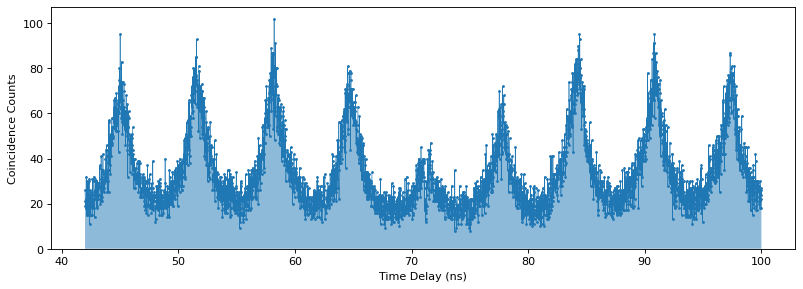

In [2]:
#Generating the plots for the co and cross polarized data 
# date = "11_30_21_1uW"
# start = 0
# stop = 150

#For 8/18/21 data
#date = "08_18_21"
#start = 43
#stop = 147

#For 7/24/21 data
#date = "07_24_21"
#start = 54
#stop = 158

#For 03/14/22 data
date = "03_14_22"
start = 42
stop = 100

time_co,coincidences_co = generate_data('quasi_res_HOM_co_' + date + '.dat',start,stop,1)
#time_cross,coincidences_cross= generate_data('quasi_res_HOM_cross_' + date + '.dat',start,stop,10)


#Plotting co polarized data:
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.fill_between(time_co,coincidences_co,alpha=0.5)
plt.ylim(bottom = 0)
#plt.ylim(top = 50)


In [3]:
#Code for other plots

#Plotting cross polarized data:
# plt.figure(figsize=(12, 4), dpi=80)
# plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3',color = 'orange')
# plt.ylabel('Coincidence Counts')
# plt.xlabel('Time Delay (ns)')
# plt.ylim(bottom = 0)
# #plt.ylim(top = 50)
# plt.fill_between(time_cross,coincidences_cross,alpha=0.5,facecolor='orange')

# #Plotting ontop of eachother (without difference in mean values)
# plt.figure(figsize=(12, 4), dpi=80)
# plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
# plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3')
# plt.ylabel('Coincidence Counts')
# plt.xlabel('Time Delay (ns)')
# plt.ylim(bottom = 0)
# #plt.ylim(top = 50)

# #Plotting ontop of eachother (with difference in mean values)
# plt.figure(figsize=(12, 4), dpi=80)
# plt.plot(time_co,coincidences_co - diff,".-",lw = '0.5', ms = '3')
# plt.plot(time_cross,coincidences_cross,".-",lw = '0.5', ms = '3')
# plt.ylabel('Coincidence Counts')
# plt.xlabel('Time Delay (ns)')
# #plt.ylim(bottom = 0)
# #plt.ylim(top = 50)


0.0576


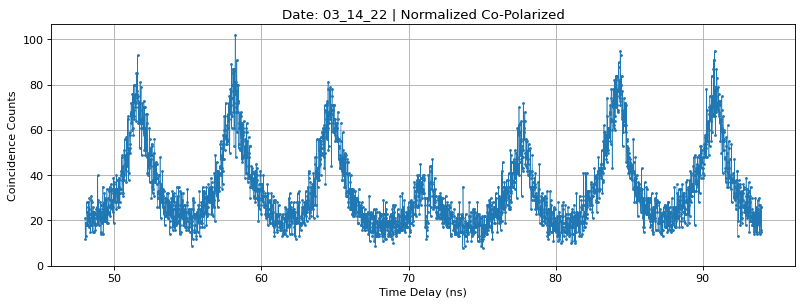

In [4]:
#Generating plots for a wider view
#For 8/18 data 
#date = "08_18_21"
#date = "09_15_21"
#date = "11_30_21_4uW"
#start = 0
#stop = 150

#For 7/24 data
#date = "07_24_21"
#start = 84
#stop = 128

#For 03/14/22 data
date = "03_14_22"
start = 48
stop = 94

time_co,coincidences_co = generate_data('quasi_res_HOM_co_' + date + '.dat',start,stop,1)
print(dark_counts(16000,9000,5,16,8))
coincidences_co = coincidences_co -  dark_counts(16000,9000,5,16*1,8)


#Plotting ontop of eachother (without difference in mean values)
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(time_co,coincidences_co,".-",lw = '0.5', ms = '3')
plt.ylabel('Coincidence Counts')
plt.xlabel('Time Delay (ns)')
plt.grid(True)
#pltt.set_xticks(0)
plt.ylim(bottom = 0)
title = date+" | Normalized Co-Polarized"
plt.title("Date: "+title)
plt.savefig(title)


In [27]:
#Fitting Lorentzians
#Link to fitting package documentation: https://lmfit.github.io/lmfit-py/builtin_models.html
from lmfit import Model 
from scipy.optimize import curve_fit

def lorenztian(x,A,mu,sigma):
    return ( (A/np.pi)*(sigma / ( (x - mu)**2  + sigma**2 ) ) )

# Function below is based off Reimer et al. 2016 suppl info
'''
def broadened_dist(x,A,C,d_epsilon,d_omega):
    #x = tau - tau0
    denom = 2*np.sqrt( np.pi*(1 + d_epsilon**2) )
    num = np.exp( (d_epsilon**2)*(x**2)/(1 + d_epsilon**2) ) - np.exp(-(d_omega**2)*(x**2)/4)
    return A*( np.exp(-x**2)*(num/denom) ) + C
'''

def broadened_dist(x,A,C,d_omega):
    #x = tau - tau0
    denom = 2*np.sqrt( np.pi*(1 + 0**2) )
    num = np.exp( (0**2)*(x**2)/(1 + 0**2) ) - np.exp(-(d_omega**2)*(x**2)/4)
    return A*( np.exp(-x**2)*(num/denom) ) + C

def area_under_curve(t,fit):
    curve = lorenztian(t,fit['A'],fit['mu'],fit['sigma'])
    return np.sum(curve),curve

def get_best_fit(fit):
    return fit.best_fit

def visibility(opt,curves):
    [A3,A2,A1,A0,A1p,A2p,A3p] = map(np.sum,curves)
    As = np.mean([A2,A2p])
    #print(A3,A2,A1,A0,A1p,A2p,A3p)
    #print(As)

    if opt == 0:
        # Visbility equation for pulse separation distances of ~ 4-8ns
        return (1 - A0/( 2/3*(A1+A1p)/2 ))
    if opt == 1:
        # Visibility equation for pulse separation distances of 12.5ns, which I believe also applies 
        # to the 6.5ns delay in my situation.
        return (1 - A0/(As/2))

def exp_corrections(eps,R,T,g2,V_raw):
    #V = (1/eps**2)*( 2*g2 + (R**2 + T**2 )/(2*R*T) - V_raw*(2 + g2*(R**2 + T**2 )/2*R*T ) )
    V = (1/eps**2)*((R**2 + T**2)/(2*R*T) - 1 + V_raw)
    return V


Raw visibility : -0.19009434210457088
Fit visibility for Thoma Eq 3: -0.2089973291770073
Corrected visibility: -0.21063084997736387


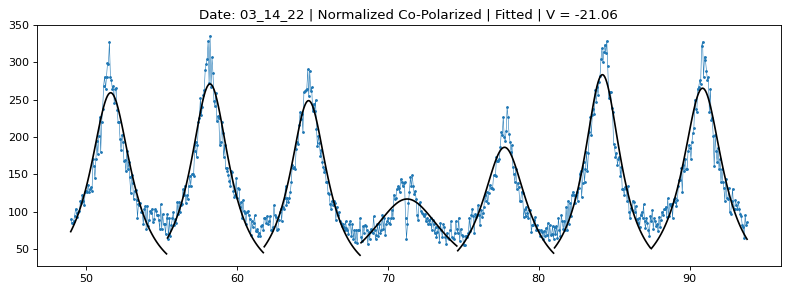

In [26]:
# Determing: 1) timing window which contains 2) 5 peaks
num_peaks = 7

#date = "11_30_21_1uW"
#start = 53
#stop = 98

#For 8/18 data
#date = "08_18_21"
#date = "09_15_21"
#start = 73
#stop = 117

#For 7/24 data
#date = "07_24_21"
#start = 84
#stop = 128

#For 03/14/22 data
date = "03_14_22"
start = 49
stop = 94

time_window = stop-start
mid = (start+stop)/2
# Data is selected as a time_window long subset of the entire set. 
# This is chosen as it is roughly the time window which contains a full number of peaks.
t,data = generate_data('quasi_res_HOM_co_' + date + '.dat',start,stop,4)

# Here I am selecting selecting the points for each of the different peaks (based off Thoma et al.)
# by reducing the number of points in the data in order to have them divide evenly by the number of 
# peaks I want to include.
num_points = np.size(data)
rem = num_points%num_peaks
#data_window = data[0:(num_points - rem)] - min(data)
data_window = data[0:(num_points - rem)] - dark_counts(16000,9000,5,16*1,8)
t_window = t[0:(num_points - rem)]

[P3,P2,P1,P0,P1p,P2p,P3p] = np.split(data_window,num_peaks)
[t3,t2,t1,t0,t1p,t2p,t3p] = np.split(t_window,num_peaks)

#Raw (unfitted) visibilites:
v_raw_unfit = visibility(1,[P3,P2,P1,P0,P1p,P2p,P3p])
print("Raw visibility : "+str(v_raw_unfit))

#Fitting peaks
curve = Model(lorenztian)
P3_fit = curve.fit(P3, x = t3, A = 180, mu = start + 7, sigma = 1.5)
P2_fit = curve.fit(P2, x = t2, A = 180, mu = start + 14, sigma = 1.5)
P1_fit = curve.fit(P1, x = t1, A = 170, mu = mid - 7, sigma = 1.5)
P0_fit = curve.fit(P0, x = t0, A = 100, mu = mid, sigma = 1.5)
P1p_fit = curve.fit(P1p, x = t1p, A = 180, mu = mid + 7, sigma = 1.5)
P2p_fit = curve.fit(P2p, x = t2p, A = 170, mu = stop - 14, sigma = 1.5)
P3p_fit = curve.fit(P3p, x = t3p, A = 180, mu = stop - 7, sigma = 1.5)

# Visibility equation for pulse separation distances of 12.5ns, which I believe also applies 
# to the 6.5ns delay in my situation.
bestfits= map(get_best_fit,[P3_fit,P2_fit,P1_fit,P0_fit,P1p_fit,P2p_fit,P3p_fit])
v_raw_fit = visibility(1,bestfits)
print("Fit visibility for Thoma Eq 3: "+str(v_raw_fit))

v_corr = exp_corrections(0.95,0.5,0.5,0,v_raw_unfit)
print("Corrected visibility: "+str(v_corr))

plt.figure(figsize=(12, 4), dpi=80)
title = date+" | Normalized Co-Polarized | Fitted"
plt.plot(t_window,data_window,".-",lw = '0.5', ms = '3')
plt.plot(t3,P3_fit.best_fit,'k-')
plt.plot(t2,P2_fit.best_fit,'k-')
plt.plot(t1,P1_fit.best_fit,'k-')
plt.plot(t0,P0_fit.best_fit,'k-')
plt.plot(t1p,P1p_fit.best_fit,'k-')
plt.plot(t2p,P2p_fit.best_fit,'k-')
plt.plot(t3p,P3p_fit.best_fit,'k-')
plt.title("Date: "+title+" | V = "+str(round(100*v_corr,2)))
plt.savefig(title)

[ 1.73542934  0.48859289 16.26224145]


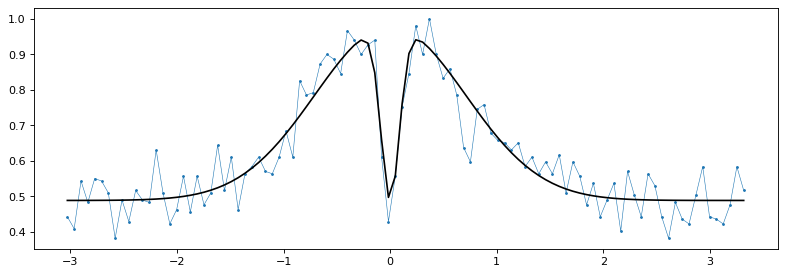

In [28]:
#Note: It is proving difficult to fit the more complicated function from Michael's paper.
#Hence I will just stick with fitting the curve with a standard Lorentzian.

#Center fit
popt, pcov = curve_fit(broadened_dist, t0 - 71.26, P0/max(P0))
print(popt)
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(t0 - 71.26,P0/max(P0),".-",lw = '0.5', ms = '3')
plt.plot(t0 - 71.26, broadened_dist(t0 - 71.26, *popt),'k-')
#print(broadened_dist(t0, *popt))
#plt.plot(t0, broadened_dist(t0-105, *[2,3,5]))



In [8]:
#t_range = np.linspace(79,111,200)
#A1,P1_curve = area_under_curve(t_range,P1_fit.best_values)
#A0,P0_curve = area_under_curve(t_range,P0_fit.best_values)
#A1p,P1p_curve = area_under_curve(t_range,P1p_fit.best_values)

#Calculating the areas under the fitted curves
#A3 = np.sum(P3_fit.best_fit)
#A2 = np.sum(P2_fit.best_fit)
#A1 = np.sum(P1_fit.best_fit)
#A0 = np.sum(P0_fit.best_fit)
#A1p = np.sum(P1p_fit.best_fit)
#A2p = np.sum(P2p_fit.best_fit)
#A3p = np.sum(P3p_fit.best_fit)

#P3_fit = curve.fit(P3[:-20], x = t3[:-20], A = 180, mu = start + 7, sigma = 3)
#P2_fit = curve.fit(P2[:-10], x = t2[:-10], A = 180, mu = start + 14, sigma = 3)
#P1_fit = curve.fit(P1[:-10], x = t1[:-10], A = 170, mu = mid - 7, sigma = 3)
#P0_fit = curve.fit(P0[20:-20], x = t0[20:-20], A = 100, mu = mid, sigma = 3)
#P1p_fit = curve.fit(P1p[10:], x = t1p[10:], A = 180, mu = mid + 7, sigma = 3)
#P2p_fit = curve.fit(P2p[10:-10], x = t2p[10:-10], A = 170, mu = stop - 14, sigma = 3)
#P3p_fit = curve.fit(P3p[40:-10], x = t3[40:-10], A = 180, mu = stop - 7, sigma = 3)